<a href="https://colab.research.google.com/github/PratikhyaManas/Detectron2_ObjectDetection/blob/master/ObjectDetection_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection using Detectron2**

# **Installing the Dependencies**

In [1]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 26kB/s 
     |████████████████████████████████| 4.1MB 27.9MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 5.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=872cf0b6ae86fa890554403bbe7c672baecc00ef58fbd75222a87f6d1a48107a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 1.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200506-cp36-none-any.whl size=40569 sha256=a2e41292508b91c0f012349eb78a47451e85f47a7ecd9b277c0845fddb8523de
  Stored in directory: /root/.cache/pip/wheels/3f/db/ab/307827ba85b8cc1d288f096909499ecdbcac90db4edaa088fe
Successfully built fvcore


# **Importing libraries**

In [0]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# **Install Kaggle API**

In [4]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 4.1MB/s 
     |████████████████████████████████| 5.3MB 7.7MB/s 
     |████████████████████████████████| 112kB 57.0MB/s 
     |████████████████████████████████| 112kB 56.9MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 


In [0]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<kaggle key>"

In [6]:
!kaggle datasets download -d tannergi/chess-piece-detection

 94% 156M/166M [00:01<00:00, 81.1MB/s]
100% 166M/166M [00:01<00:00, 88.5MB/s]


In [7]:
!unzip chess-piece-detection.zip

Archive:  chess-piece-detection.zip
  inflating: Chess Detection/annotations/IMG_1989.xml  
  inflating: Chess Detection/annotations/IMG_1990.xml  
  inflating: Chess Detection/annotations/IMG_1991.xml  
  inflating: Chess Detection/annotations/IMG_1992.xml  
  inflating: Chess Detection/annotations/IMG_1993.xml  
  inflating: Chess Detection/annotations/IMG_1994.xml  
  inflating: Chess Detection/annotations/IMG_1995.xml  
  inflating: Chess Detection/annotations/IMG_1996.xml  
  inflating: Chess Detection/annotations/IMG_1997.xml  
  inflating: Chess Detection/annotations/IMG_1998.xml  
  inflating: Chess Detection/annotations/IMG_1999.xml  
  inflating: Chess Detection/annotations/IMG_2000.xml  
  inflating: Chess Detection/annotations/IMG_2001.xml  
  inflating: Chess Detection/annotations/IMG_2002.xml  
  inflating: Chess Detection/annotations/IMG_2003.xml  
  inflating: Chess Detection/annotations/IMG_2004.xml  
  inflating: Chess Detection/annotations/IMG_2005.xml  
  inflating:

# **Register Dataset**

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2
import xml.etree.ElementTree as ET


# write a function that loads the dataset into detectron2's standard format
def get_dataset_dicts(annotation_path, image_path):
    classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

    dataset_dicts = []
    for filename in os.listdir(annotation_path):
        record = {}
        root = ET.parse(os.path.join(annotation_path, filename)).getroot()
        record["file_name"] = os.path.join(image_path, root.find('filename').text)
        record["height"] = 2248
        record["width"] = 4000

        objs = []
        for member in root.findall('object'):
          obj = {
              'bbox': [int(member[4][0].text), int(member[4][1].text), int(member[4][2].text), int(member[4][3].text)],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': classes.index(member[0].text),
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [0]:

from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

DatasetCatalog.register('chess_piece_dataset', lambda: get_dataset_dicts('Chess Detection/annotations', 'Chess Detection/images'))
MetadataCatalog.get('chess_piece_dataset').set(thing_classes=classes)
chess_metadata = MetadataCatalog.get('chess_piece_dataset')

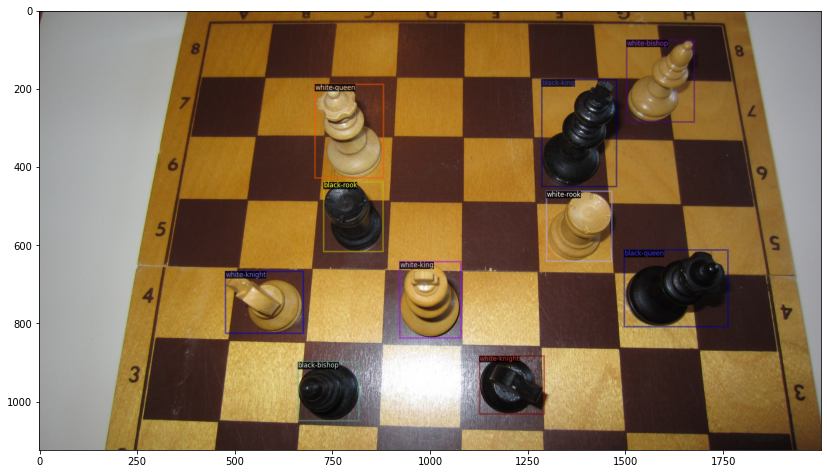

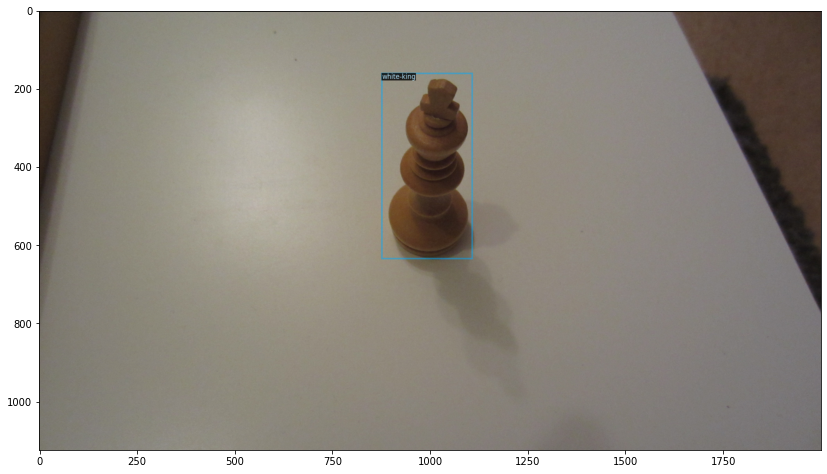

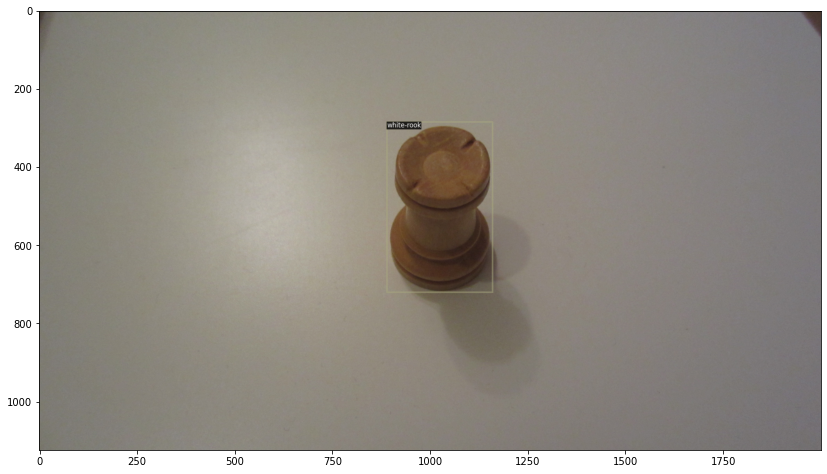

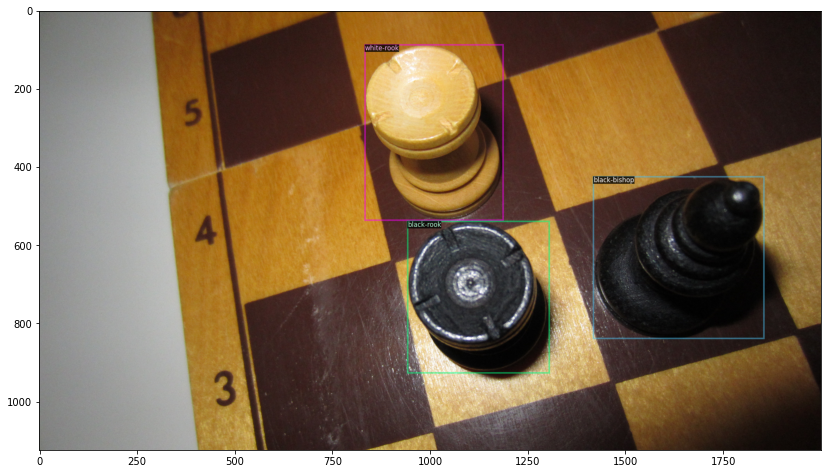

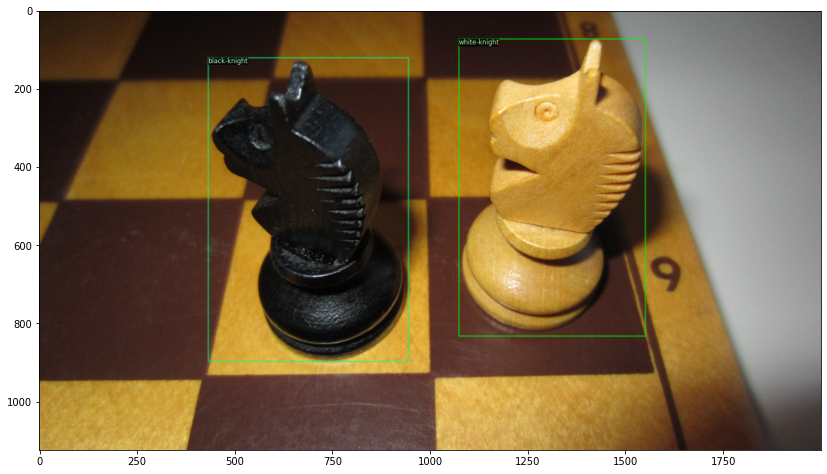

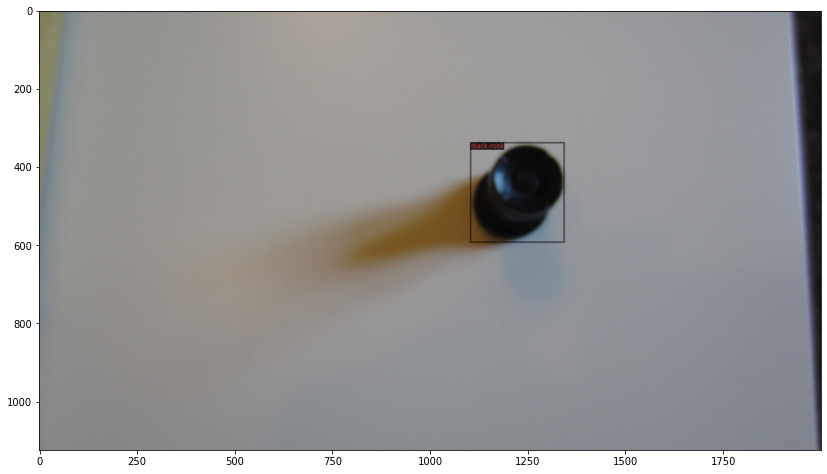

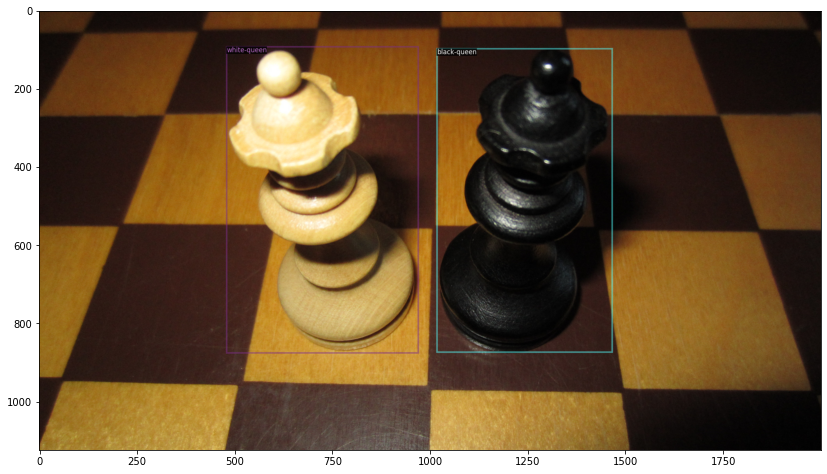

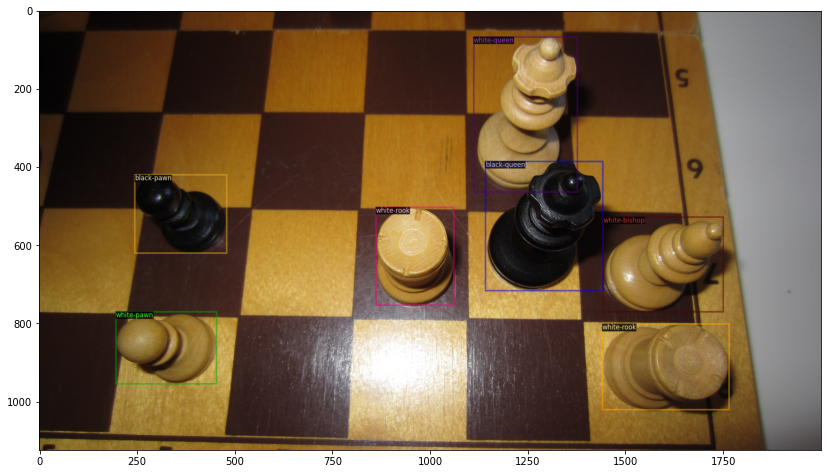

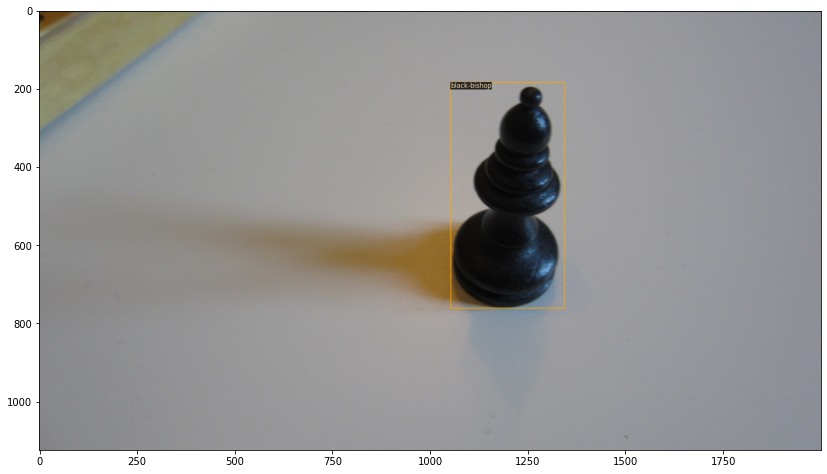

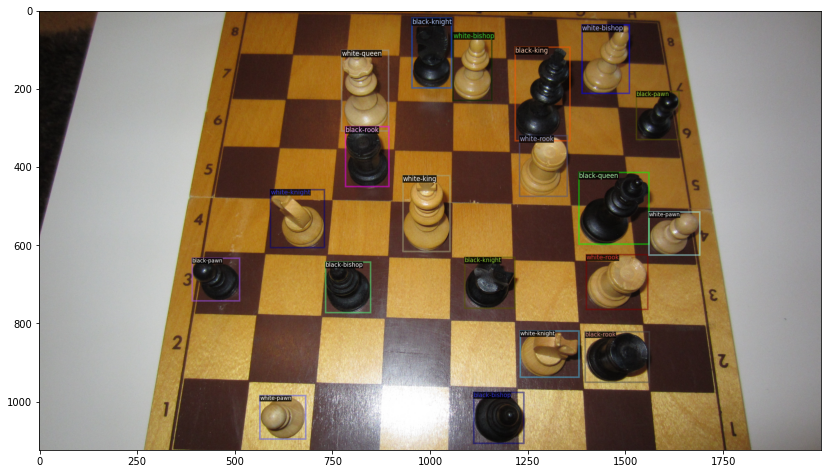

In [10]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('chess_piece_dataset')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=chess_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# **Train the Model**

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('chess_piece_dataset',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/06 08:52:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:03, 69.5MB/s]                           


[05/06 08:52:43 d2.engine.train_loop]: Starting training from iteration 0
[05/06 08:53:00 d2.utils.events]:  eta: 0:13:51  iter: 19  total_loss: 2.366  loss_cls: 1.839  loss_box_reg: 0.464  loss_rpn_cls: 0.004  loss_rpn_loc: 0.007  time: 0.8375  data_time: 0.4422  lr: 0.000400  max_mem: 3667M
[05/06 08:53:16 d2.utils.events]:  eta: 0:13:13  iter: 39  total_loss: 1.154  loss_cls: 0.567  loss_box_reg: 0.576  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.8227  data_time: 0.3819  lr: 0.000799  max_mem: 3667M
[05/06 08:53:32 d2.utils.events]:  eta: 0:12:54  iter: 59  total_loss: 1.101  loss_cls: 0.499  loss_box_reg: 0.594  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  time: 0.8181  data_time: 0.3995  lr: 0.001199  max_mem: 3667M
[05/06 08:53:49 d2.utils.events]:  eta: 0:12:37  iter: 79  total_loss: 0.926  loss_cls: 0.421  loss_box_reg: 0.480  loss_rpn_cls: 0.000  loss_rpn_loc: 0.008  time: 0.8165  data_time: 0.4048  lr: 0.001598  max_mem: 3667M
[05/06 08:54:05 d2.utils.events]:  eta: 0:12:1

# **Inference Model**

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("chess_piece_dataset", )
predictor = DefaultPredictor(cfg)

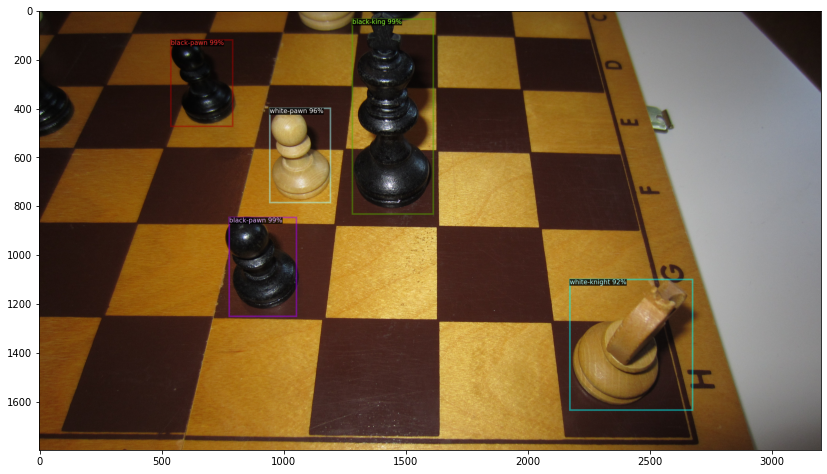

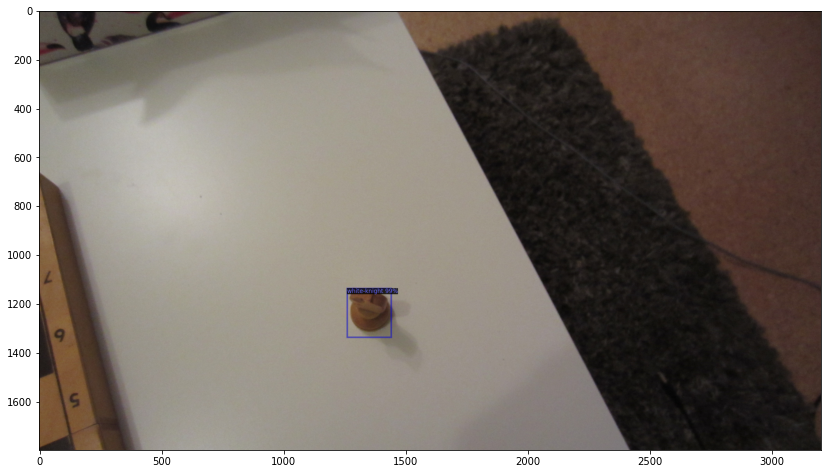

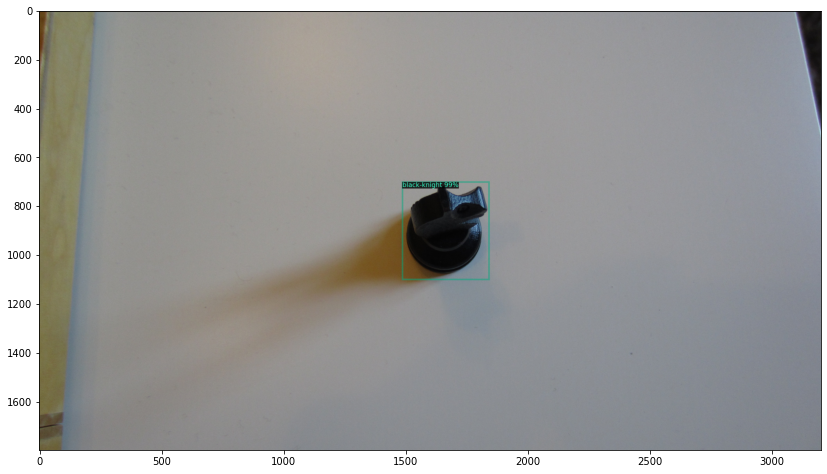

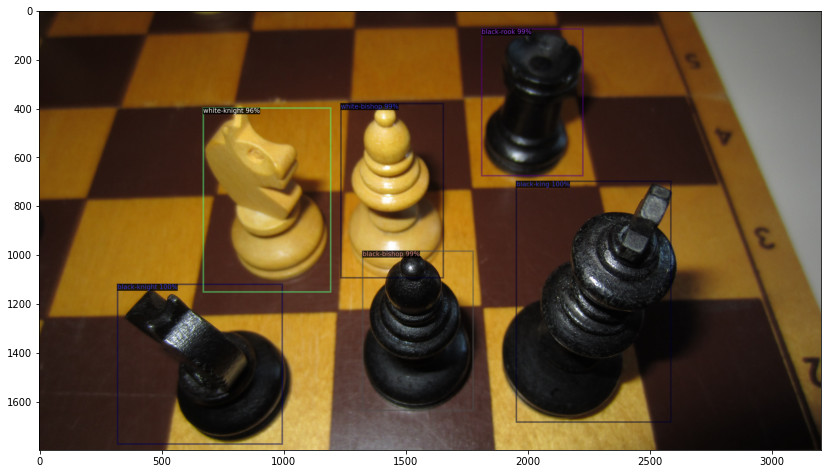

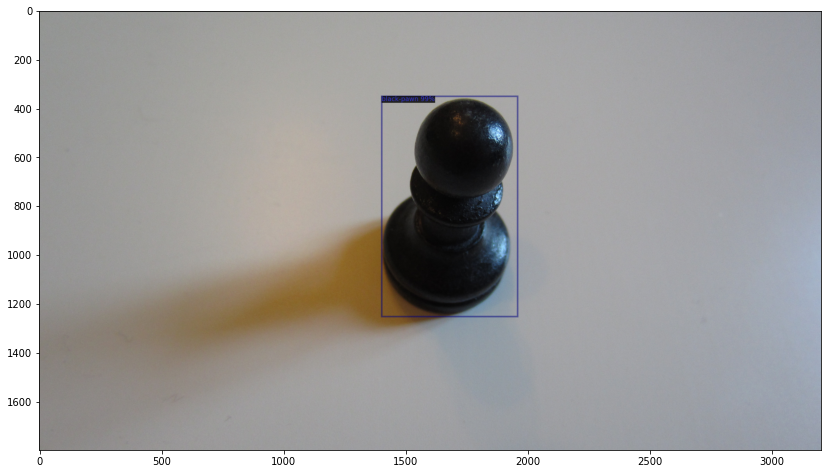

In [13]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('chess_piece_dataset')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=chess_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()